In [3]:
from datasets import load_dataset
from sentence_transformers import SentenceTransformer
from tqdm.notebook import tqdm
import numpy as np
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from asset.Model import classify_text
from asset.Visualize import get_n_colors_from_plotly_scale
import os
named_colorscales = px.colors.named_colorscales()

os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = './cert/cdp-rd-vertex-ai.json'

In [4]:
data = load_dataset("community-datasets/disaster_response_messages",split="train")
data_df = data.to_pandas().sample(2000)

In [5]:
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
all_emb = []
for i in tqdm(range(0,len(data_df),10)):
    all_emb.append(model.encode(data_df['message'].values[i:i+10].tolist()))

  0%|          | 0/200 [00:00<?, ?it/s]

In [6]:
sentence_embeddings = np.concatenate(all_emb,axis=0)
tsne = TSNE(n_components=3)
tsne_results = tsne.fit_transform(sentence_embeddings)


/Users/chris_lo/PycharmProjects/TextClusterInLLM/.venv/lib/python3.11/site-packages/threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


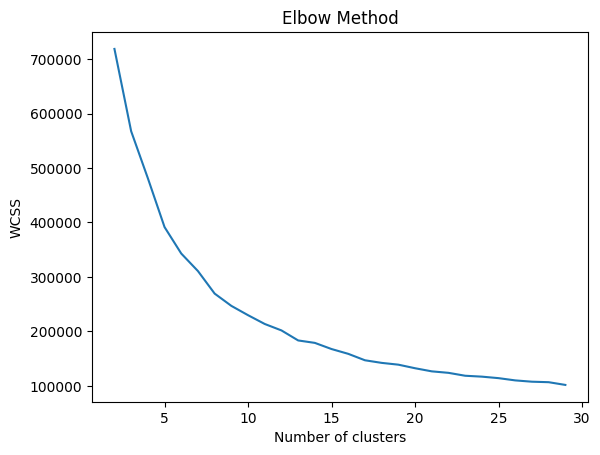

In [7]:
# WCSS代表群內平方和
# 計算每一群中的每一個資料點到群中心的距離
wcss = []
for i in range(2, 30):
    kmeans = KMeans(n_clusters=i, init='k-means++')
    kmeans.fit(tsne_results)
    wcss.append(kmeans.inertia_)
plt.plot(range(2, 30), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')  
plt.show()


In [8]:
n_cluster = 15
k_means = KMeans(n_clusters=n_cluster,init='k-means++').fit(tsne_results)
k_means_results = k_means.predict(tsne_results)

data_df[['t0','t1','t2']] = tsne_results
data_df['cluster'] = k_means_results


In [9]:

msg_clf = {}
for id,df in data_df.groupby('cluster'):
    ai_msg = classify_text(df['message'].to_string())
    msg_clf[id] = ai_msg
    
print(msg_clf)

{0: '人道援助、救灾、捐款及相关信息', 1: '地震信息、灾情及求助咨询', 2: '天气、气候、农业和灾害信息', 3: '寻求帮助与资源', 4: '灾害求助：水、电、住所等紧急需求', 5: '自然灾害情况与求助', 6: '食物、水、医疗、物资需求与捐赠', 7: '全球冲突、安全与政治动态。', 8: '飓风桑迪：准备、影响与恢复', 9: '信息、学校、旅行、移民及援助请求', 10: '灾民急需食物、水、住所、医疗援助。', 11: '灾情、救援、安置与援助', 12: '灾民请求紧急援助和信息', 13: '应对全球疾病爆发和健康危机', 14: '食物、工作、健康、信息、求助'}


In [12]:
data_df['cluster_name'] = data_df['cluster'].apply(lambda c:msg_clf[c])
data_df['cluster_name'] = data_df['cluster_name'].apply(lambda s: '-'.join(list(set(s.split('\n')))))

In [13]:
n_cluster = data_df['cluster'].nunique()
category_colors = get_n_colors_from_plotly_scale(n_cluster, scale_name='Plotly')

fig = go.Figure()
for color,(c,df) in enumerate(data_df.groupby('cluster')):
    fig.add_trace(go.Scatter3d(
        x=df['t0'],
        y=df['t1'],
        z=df['t2'],
        mode='markers',
        text=df['message'],
        textposition="middle center",
         marker=dict(
            size=8,
            color=category_colors[c],  # 每個類別使用單一顏色
            symbol='circle',
            opacity=0.75,
        ),
        name=df['cluster_name'].astype(str).values[0],
        showlegend=True,
        hovertemplate='<b>%{text} </b><br>' +
                      'X: %{x:.2f}<br>' +
                      'Y: %{y:.2f}<br>' +
                      'Z: %{z:.2f}<extra></extra>'
    ))
    center_text = '[中心點]' + df['cluster_name'].astype(str).values[0] 
    fig.add_trace(
        go.Scatter3d(
            x=[k_means.cluster_centers_[c,0]],
            y=[k_means.cluster_centers_[c,1]],
            z=[k_means.cluster_centers_[c,2]],
            mode='markers',
            marker=dict(
                size=10,
                color=category_colors[c],
                symbol='cross',
                opacity=1
        ),
        name=center_text,
        text=center_text,
        # hovertemplate='<b>%{text}</b><br>' +
        #               'X: %{x:.2f}<br>' +
        #               'Y: %{y:.2f}<br>' +
        #               'Z: %{z:.2f}<extra></extra>',
        showlegend=False
        )
    )


# 更新佈局，調整圖例位置
fig.update_layout(
    scene=dict(
        xaxis_title='X Axis',
        yaxis_title='Y Axis',
        zaxis_title='Z Axis'
    ),
    title='對話分群(sampling 2000 points.)',
    margin=dict(l=0, r=0, b=0, t=40),
    legend=dict(
        x=1.02,  # 將圖例放在圖的右側 (1.0 代表最右邊)
        y=1,     # 將圖例放在圖的頂部 (1.0 代表最頂部)
        xanchor="left", # 圖例的水平錨點為左側
        yanchor="top",  # 圖例的垂直錨點為頂部
        bgcolor="rgba(255, 255, 255, 0.5)", # 背景顏色 (半透明白色)
        bordercolor="Black",
        borderwidth=1
    )
)

fig.write_html("./cluster.html")